# Custom training: walkthrough
Source: https://www.tensorflow.org/alpha/tutorials/eager/custom_training_walkthrough#tensorflow_programming

## TensorFlow programming
This guide uses these high-level TensorFlow concepts:

- Use TensorFlow's default eager execution development environment,
- Import data with the Datasets API,
- Build models and layers with TensorFlow's Keras API.

This tutorial is structured like many TensorFlow programs:

- Import and parse the data sets.
- Select the type of model.
- Train the model.
- Evaluate the model's effectiveness.
- Use the trained model to make predictions.


In [1]:
import os
import matplotlib.pyplot as plt

!pip install -q tensorflow==2.0.0-alpha0
import tensorflow as tf

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.0.0-alpha0
Eager execution: True


## The Iris classification problem
- Iris setosa
- Iris virginica
- Iris versicolor

### Import and parse the training dataset 

### Download the dataset


In [2]:
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

8192/2194 [================================================================================================================] - 0s 0us/step
Local copy of the dataset file: C:\Users\HP\.keras\datasets\iris_training.csv


### Inspect the data

In [3]:
!head -n5 {train_dataset_fp}

'head' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
# column order in CSV file
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species


Each label is associated with string name (for example, "setosa"), but machine learning typically relies on numeric values. The label numbers are mapped to a named representation, such as:

- 0: Iris setosa
- 1: Iris versicolor
- 2: Iris virginica


In [5]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

### Create a tf.data.Dataset

In [6]:
batch_size = 32

train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size, 
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

In [7]:
features, labels = next(iter(train_dataset))

print(features)

OrderedDict([('sepal_length', <tf.Tensor: id=64, shape=(32,), dtype=float32, numpy=
array([7.3, 5.8, 5.7, 7.6, 5.7, 6.3, 4.7, 7.7, 6.5, 5.7, 6.3, 6.7, 5.8,
       5.7, 6.4, 6.8, 5.7, 6.4, 5.3, 5. , 6. , 6.9, 5.2, 5.6, 7.4, 4.8,
       6.3, 7.2, 5.9, 5.1, 4.8, 5.5], dtype=float32)>), ('sepal_width', <tf.Tensor: id=65, shape=(32,), dtype=float32, numpy=
array([2.9, 2.7, 3.8, 3. , 3. , 2.3, 3.2, 3.8, 3. , 2.8, 2.5, 3.1, 2.6,
       4.4, 2.8, 3.2, 2.8, 3.2, 3.7, 3.3, 2.2, 3.1, 2.7, 2.5, 2.8, 3. ,
       3.3, 3. , 3.2, 3.8, 3.4, 3.5], dtype=float32)>), ('petal_length', <tf.Tensor: id=62, shape=(32,), dtype=float32, numpy=
array([6.3, 5.1, 1.7, 6.6, 4.2, 4.4, 1.3, 6.7, 5.8, 4.5, 5. , 5.6, 4. ,
       1.5, 5.6, 5.9, 4.1, 4.5, 1.5, 1.4, 5. , 5.1, 3.9, 3.9, 6.1, 1.4,
       6. , 5.8, 4.8, 1.6, 1.6, 1.3], dtype=float32)>), ('petal_width', <tf.Tensor: id=63, shape=(32,), dtype=float32, numpy=
array([1.8, 1.9, 0.3, 2.1, 1.2, 1.3, 0.2, 2.2, 2.2, 1.3, 1.9, 2.4, 1.2,
       0.4, 2.2, 2.3, 1.3, 1.5, 0

You can start to see some clusters by plotting a few features from the batch:



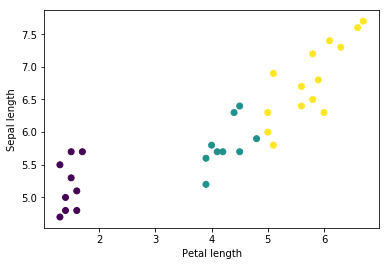

In [8]:
plt.scatter(features['petal_length'],
            features['sepal_length'],
            c=labels,
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length");

To simplify the model building step, create a function to repackage the features dictionary into a single array with shape: `(batch_size, num_features)`.



In [9]:
def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

Then use the tf.data.Dataset.map method to pack the features of each `(features,label)` pair into the training dataset:



In [10]:
train_dataset = train_dataset.map(pack_features_vector)

In [11]:
features, labels = next(iter(train_dataset))

print(features[:5])

tf.Tensor(
[[7.3 2.9 6.3 1.8]
 [5.8 2.7 5.1 1.9]
 [5.7 3.8 1.7 0.3]
 [7.6 3.  6.6 2.1]
 [5.7 3.  4.2 1.2]], shape=(5, 4), dtype=float32)


## Select the type of model
### Create a model using Keras

In [12]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

### Using the model
Let's have a quick look at what this model does to a batch of features:



In [13]:
predictions = model(features)
predictions[:5]

<tf.Tensor: id=229, shape=(5, 3), dtype=float32, numpy=
array([[-1.3174465 ,  1.2131921 ,  0.24083157],
       [-0.901429  ,  0.87106735,  0.12427242],
       [-0.05123605, -0.18319908, -0.14277247],
       [-1.3346376 ,  1.235656  ,  0.23837112],
       [-0.7007018 ,  0.85640126,  0.003292  ]], dtype=float32)>

In [14]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: id=235, shape=(5, 3), dtype=float32, numpy=
array([[0.05460851, 0.6859663 , 0.2594251 ],
       [0.10336369, 0.6083498 , 0.2882866 ],
       [0.3585641 , 0.31423604, 0.32719982],
       [0.05293583, 0.69185346, 0.25521067],
       [0.12875205, 0.61093557, 0.26031235]], dtype=float32)>

Taking the tf.argmax across classes gives us the predicted class index. But, the model hasn't been trained yet, so these aren't good predictions.



In [15]:
print("Prediction: {}".format(tf.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))

Prediction: [1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 0]
    Labels: [2 2 0 2 1 1 0 2 2 1 2 2 1 0 2 2 1 1 0 0 2 2 1 1 2 0 2 2 1 0 0 0]


## Train the model
### Define the loss and gradient function

In [16]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [17]:
def loss(model, x, y):
  y_ = model(x)
  
  return loss_object(y_true=y, y_pred=y_)


l = loss(model, features, labels)
print("Loss test: {}".format(l))

Loss test: 0.9850744605064392


Use the tf.GradientTape context to calculate the gradients used to optimize our model.


In [18]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

### Create an optimizer

In [19]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [20]:
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables))

print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model, features, labels).numpy()))

Step: 0, Initial Loss: 0.9850744605064392
Step: 1,         Loss: 0.8716604709625244


### Training loop
1. Iterate each epoch. An epoch is one pass through the dataset.
2. Within an epoch, iterate over each example in the training Dataset grabbing its features (x) and label (y).
3. Using the example's features, make a prediction and compare it with the label. Measure the inaccuracy of the prediction  and use that to calculate the model's loss and gradients.
4.Use an optimizer to update the model's variables.
5. Keep track of some stats for visualization.
6. Repeat for each epoch.

In [21]:
## Note: Rerunning this cell uses the same model variables

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg(loss_value)  # add current batch loss
    # compare predicted label to actual label
    epoch_accuracy(y, model(x))

  # end epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())
  
  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 0.814, Accuracy: 70.000%
Epoch 050: Loss: 0.061, Accuracy: 98.333%
Epoch 100: Loss: 0.049, Accuracy: 99.167%
Epoch 150: Loss: 0.045, Accuracy: 99.167%
Epoch 200: Loss: 0.041, Accuracy: 99.167%


### Visualize the loss function over time

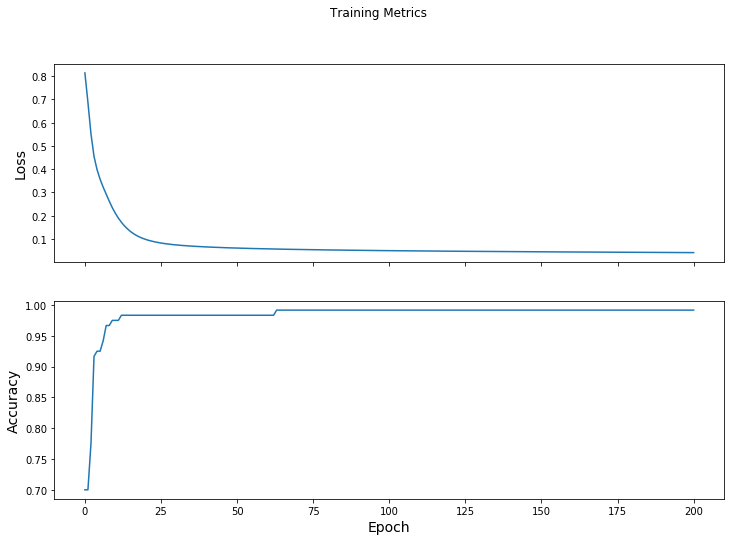

In [22]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results);

## Setup the test dataset

In [23]:
test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [24]:
test_dataset = tf.data.experimental.make_csv_dataset(
    test_fp,
    batch_size, 
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)

## Evaluate the model on the test dataset

In [25]:
test_accuracy = tf.keras.metrics.Accuracy()

for (x, y) in test_dataset:
  logits = model(x)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 96.667%


In [26]:
tf.stack([y,prediction],axis=1)

<tf.Tensor: id=164408, shape=(30, 2), dtype=int32, numpy=
array([[1, 1],
       [2, 2],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [2, 1],
       [1, 1],
       [2, 2],
       [2, 2],
       [0, 0],
       [2, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [2, 2],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 1]])>

## Use the trained model to make predictions
For now, we're going to manually provide three unlabeled examples to predict their labels. Recall, the label numbers are mapped to a named representation as:

- 0: Iris setosa
- 1: Iris versicolor
- 2: Iris virginica


In [27]:
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))

Example 0 prediction: Iris setosa (99.9%)
Example 1 prediction: Iris versicolor (100.0%)
Example 2 prediction: Iris virginica (99.6%)
